In [1]:
# Tony Bui 

# 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, precision_score
from sklearn.utils import class_weight
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from scipy import stats

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision

from imblearn.over_sampling import SMOTE

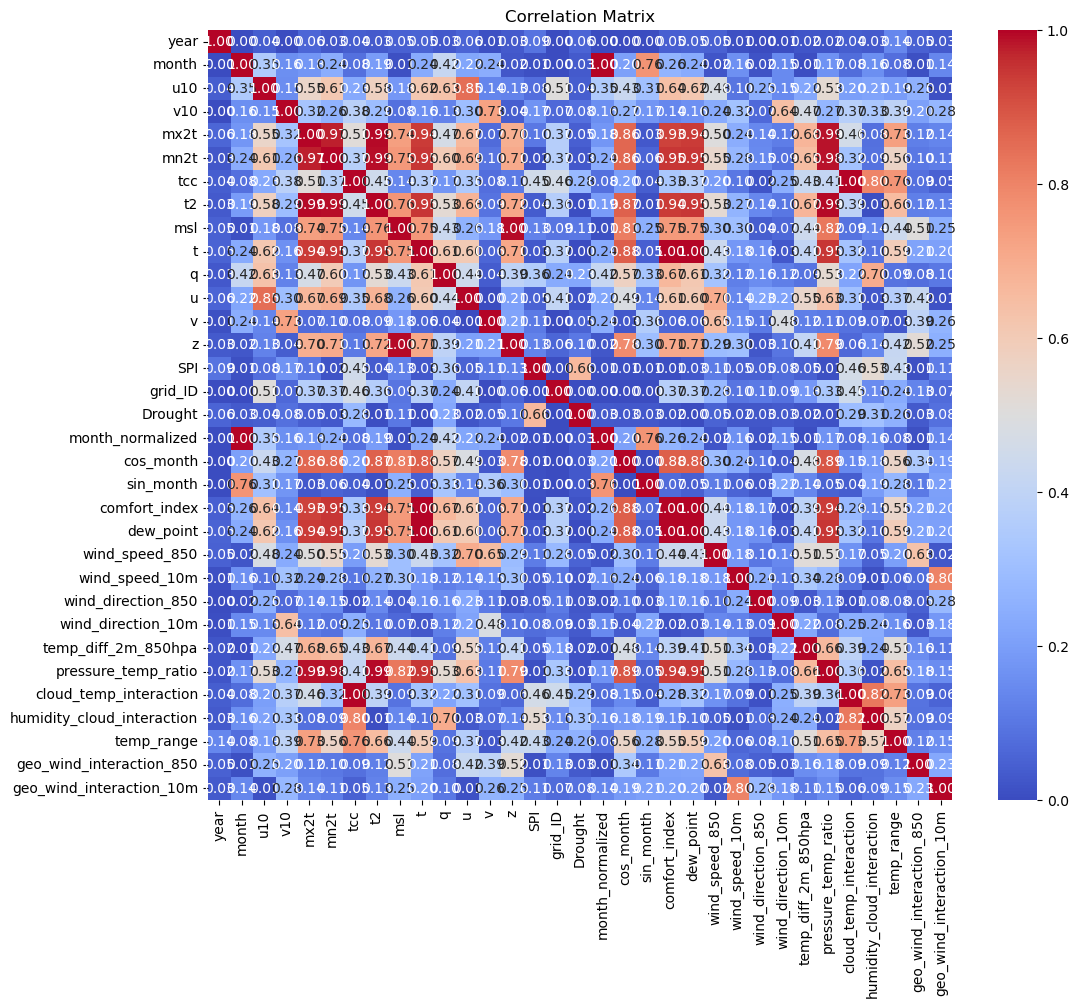

Drought Correlation
Drought                       1.000000
SPI                           0.662388
humidity_cloud_interaction    0.312491
cloud_temp_interaction        0.292999
tcc                           0.284451
temp_range                    0.256457
q                             0.226249
msl                           0.105394
z                             0.103596
v10                           0.083778
geo_wind_interaction_10m      0.082746
year                          0.058336
v                             0.051258
wind_speed_850                0.050798
mx2t                          0.045521
u10                           0.042156
geo_wind_interaction_850      0.034180
wind_direction_10m            0.034103
month_normalized              0.032305
month                         0.032305
mn2t                          0.029977
cos_month                     0.029161
sin_month                     0.027541
wind_direction_850            0.027093
wind_speed_10m                0.024920
u    

In [3]:
# For SMOTE and Dataset Distribution
random_state = 42

# Df = Classification
# Df2 = Regresseion

# Load Data
df = pd.read_csv('Climate_SPI.csv')

# Create Binary Target 'Drought' based on SPI
df['Drought'] = (df['SPI'] <= -1).astype(int)  # Drought = 1 if SPI <= -1, else 0

# Normalize the month to the range [0, 2π]
df['month_normalized'] = 2 * np.pi * (df['month'] - 1) / 12
df['cos_month'] = np.cos(df['month_normalized'])
df['sin_month'] = np.sin(df['month_normalized'])

# New features as a combination of the given
df['comfort_index'] = df['t'] - (0.55 * (1 - df['q']) * (df['t'] - 14.5))
df['dew_point'] = df['t'] - ((100 - df['q']) / 5)
df['wind_speed_850'] = np.sqrt(df['u']**2 + df['v']**2)
df['wind_speed_10m'] = np.sqrt(df['u10']**2 + df['v10']**2)
df['wind_direction_850'] = np.arctan2(df['v'], df['u'])
df['wind_direction_10m'] = np.arctan2(df['v10'], df['u10'])
df['temp_diff_2m_850hpa'] = df['t2'] - df['t']
df['pressure_temp_ratio'] = df['msl'] / (df['t2'] + 1e-9)
df['cloud_temp_interaction'] = df['tcc'] * df['t2']
df['humidity_cloud_interaction'] = df['q'] * df['tcc']
df['temp_range'] = df['mx2t'] - df['mn2t']
df['geo_wind_interaction_850'] = df['z'] * df['wind_speed_850']
df['geo_wind_interaction_10m'] = df['z'] * df['wind_speed_10m']

# Identify relevant features
correlation_matrix = df.corr().abs()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Identify features correlated with the target variable 'Drought' - Classification
print("Drought Correlation")
target_correlation = correlation_matrix['Drought']
print(target_correlation.sort_values(ascending=False))
# Identify features correlated with the target variable 'Drought' - Regression
print()
print("SPI Correlation")
target_correlation = correlation_matrix['SPI']
print(target_correlation.sort_values(ascending=False))

# Data Cleanse

# Not allowed to use
df = df.drop(['year', 'grid_ID'], axis=1)

# Redundant
df = df.drop(['month_normalized', 'month'], axis=1)
df2 = df.drop(['Drought'], axis=1)

# Drop less important features < 0.02
df = df.drop(['comfort_index', 'temp_diff_2m_850hpa', 'pressure_temp_ratio', 't2', 't', 'dew_point'], axis=1)
df2 = df2.drop(['mn2t', 'cos_month', 'sin_month', 'comfort_index', 'temp_diff_2m_850hpa', 'pressure_temp_ratio', 'geo_wind_interaction_850'], axis=1)

# Drop outliers
z_scores = stats.zscore(df2['SPI'])
df2 = df2[(z_scores < 3) & (z_scores > -3)]

# Display the number of removed outliers
print()
print(f"Removed outliers: {len(df) - len(df2)}")

# Prepare Features (X) and Target (y)
print()
print("Classification Dataset")
X = df.drop(['Drought', 'SPI'], axis=1)  # Drop target variables, keep only the predictors
y = df['Drought']  # The target variable
print("Number of predictors: ", X.shape[1])
print(X.columns)

print()
print("Regression Dataset")
X2 = df2.drop(['SPI'], axis=1)
y2 = df2['SPI']
print("Number of predictors: ", X2.shape[1])
print(X2.columns)

In [4]:
# Original Dataset: Imbalanced classes
# Split the data into training, validation, and test sets
# Classification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=random_state)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)

print(y_train.value_counts())

# Regression
X2_train, X2_temp, y2_train, y2_temp = train_test_split(X2, y2, test_size=0.3, random_state=random_state)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_temp, y2_temp, test_size=0.5, random_state=random_state)

print(y2_train.value_counts())

Drought
0    8974
1    1610
Name: count, dtype: int64
SPI
-0.259944    1
 1.194438    1
 0.693056    1
 2.099658    1
-0.697299    1
            ..
 1.340512    1
-0.076255    1
 0.249131    1
 1.236404    1
 1.545058    1
Name: count, Length: 10552, dtype: int64


In [5]:
# Classification (X)
scaler = StandardScaler()

# Fit on classification training data
scaler.fit(X_train)

# Transform classification datasets
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Regression (X2)
scaler2 = StandardScaler()

# Fit on regression training data
scaler2.fit(X2_train)

# Transform regression datasets
X2_train = scaler2.transform(X2_train)
X2_val = scaler2.transform(X2_val)
X2_test = scaler2.transform(X2_test)

# Modified Dataset: Balanced classes
smote = SMOTE(sampling_strategy=1, random_state=random_state)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [6]:
def plot_classification(model, X_test, y_test, history, threshold=0.95):
    # Test
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.95).astype(int)  # Convert probabilities to binary labels
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))
    
    # Plot accuracy
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # Calculate Balanced Accuracy
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
    print(f'Balanced Accuracy: {balanced_accuracy:.4f}')
    
    # Calculate Precision
    precision = precision_score(y_test, y_pred_binary, zero_division=1)
    print(f'Precision: {precision:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Drought', 'Drought'], 
                yticklabels=['No Drought', 'Drought'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [7]:
def ANN_Classification(num_features, X_train, y_train, output_activation, loss, metrics, weights, epochs, batch_size):
    # Build the layers
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(num_features,)),)  # Use the shape of the input data

    # Hidden layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))  
    model.add(Dense(32, activation='relu')) 
    
    # Sigmoid for Binary
    model.add(Dense(1, activation=output_activation))

    model.compile(optimizer=Adam(), loss=loss, metrics=metrics)

    if weights == -1:
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32)
    else:
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32, class_weight = weights)

    

    return history, model

In [8]:
# Custom weight to penalize
# Not neccessary for SMOTE
# class_weights = {0: 1, 1: 1}

# Little differences
# # Define an EarlyStopping callback to monitor precision
# early_stopping = EarlyStopping(
#     monitor='val_accuracy',  # Monitor precision on the validation set
#     mode='max',               # We want to maximize precision
#     patience=30,               # Number of epochs with no improvement after which training will be stopped
#     min_delta=0.001,          # Minimum change to qualify as an improvement
#     restore_best_weights=True,  # Restore model weights from the epoch with the best precision
#     verbose=1
# )
history, model = ANN_Classification(21, X_train, y_train, 'sigmoid', 'binary_crossentropy', ['accuracy'], -1, 300, 32)

Epoch 1/300
331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8487 - loss: 0.3787 - val_accuracy: 0.8642 - val_loss: 0.3131
Epoch 2/300
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8613 - loss: 0.3202 - val_accuracy: 0.8642 - val_loss: 0.3050
Epoch 3/300
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8676 - loss: 0.3142 - val_accuracy: 0.8708 - val_loss: 0.2986
Epoch 4/300
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8625 - loss: 0.3123 - val_accuracy: 0.8699 - val_loss: 0.2918
Epoch 5/300
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8686 - loss: 0.3049 - val_accuracy: 0.8735 - val_loss: 0.2905
Epoch 6/300
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8754 - loss: 0.2949 - val_accuracy: 0.8757 - val_loss: 0.2863
Epoch 7/300
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8717 - loss: 0.2981 - val_accuracy: 0.8779 - val_loss: 0.2850
Epoch 8/300
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8716 - loss: 0.2995 - val_accu

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1971
           1       0.76      0.40      0.53       297

    accuracy                           0.91      2268
   macro avg       0.84      0.69      0.74      2268
weighted avg       0.90      0.91      0.89      2268



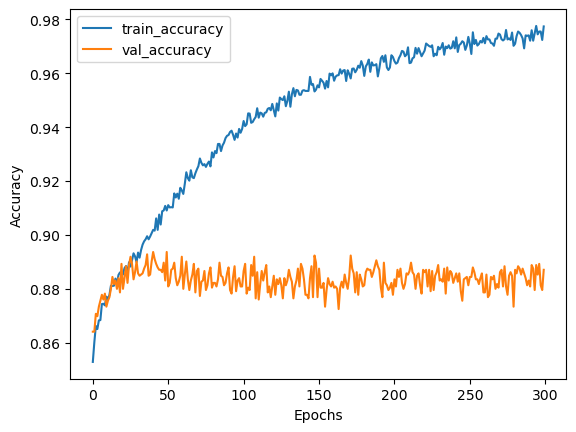

Balanced Accuracy: 0.6910
Precision: 0.7628


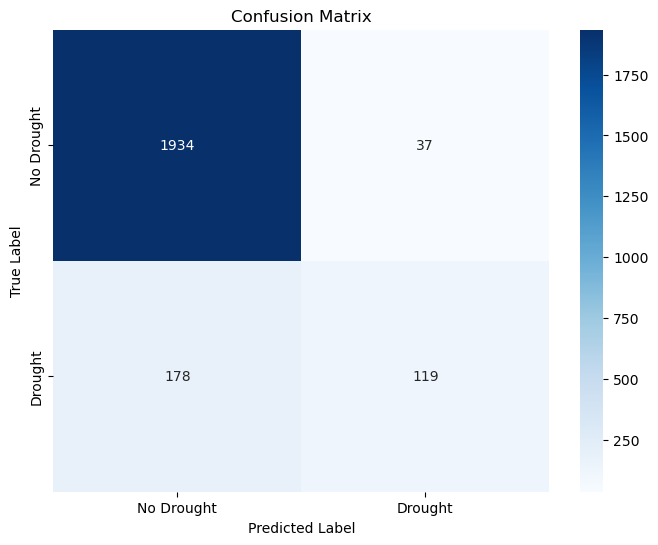

In [9]:
# Test
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.95).astype(int)  # Convert probabilities to binary labels

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate Balanced Accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
print(f'Balanced Accuracy: {balanced_accuracy:.4f}')

# Calculate Precision
precision = precision_score(y_test, y_pred_binary, zero_division=1)
print(f'Precision: {precision:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Drought', 'Drought'], 
            yticklabels=['No Drought', 'Drought'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# model.save('classification_modelv5.keras') #

In [13]:
classification_model = load_model('classification_modelv5.keras')

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1971
           1       0.62      0.46      0.53       297

    accuracy                           0.89      2268
   macro avg       0.77      0.71      0.73      2268
weighted avg       0.88      0.89      0.88      2268

Balanced Accuracy: 0.7074
Precision: 0.6154


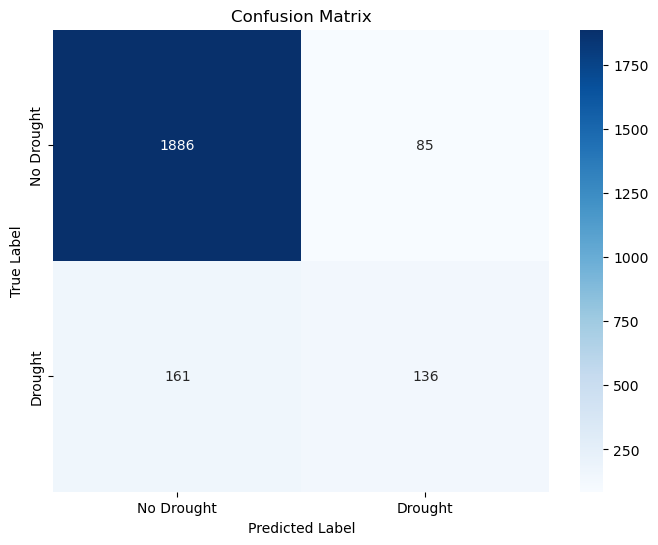

In [17]:
# Test
y_pred = classification_model.predict(X_test)
y_pred_binary = (y_pred > 0.95).astype(int)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Plot accuracy
# plt.plot(history.history['accuracy'], label='train_accuracy')
# plt.plot(history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# Calculate Balanced Accuracy
balanced_accuracy = balanced_accuracy_score(y_test, y_pred_binary)
print(f'Balanced Accuracy: {balanced_accuracy:.4f}')

# Calculate Precision
precision = precision_score(y_test, y_pred_binary, zero_division=1)
print(f'Precision: {precision:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Drought', 'Drought'], 
            yticklabels=['No Drought', 'Drought'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
def ANN_Regression(num_features, X_train, y_train, output_activation, loss, metrics, weights, epochs, batch_size):
    # Build the layers
    model = Sequential()
    
    # Input layer
    model.add(Input(shape=(num_features,)),)

    # Hidden layers    
    model.add(Dense(512, activation='linear'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='linear'))
    model.add(Dense(64, activation='relu'))  
    model.add(Dense(32, activation='linear'))

    # Linear for Continuous
    model.add(Dense(1, activation=output_activation))

    model.compile(optimizer='adam', loss=loss, metrics=metrics)
   
    if weights == -1:
        history = model.fit(X_train, y_train, validation_data=(X2_val, y2_val), epochs=epochs, batch_size=32)
    else:
        history = model.fit(X_train, y_train, validation_data=(X2_val, y2_val), epochs=epochs, batch_size=32, class_weight = weights)
    

    return history, model

In [19]:
# Regression Model
history, model = ANN_Regression(20, X2_train, y2_train, 'linear', 'mean_absolute_error', ['mae'], -1, 300, 32)

Epoch 1/300
330/330 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6245 - mae: 0.6245 - val_loss: 0.5955 - val_mae: 0.5955
Epoch 2/300
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5705 - mae: 0.5705 - val_loss: 0.5776 - val_mae: 0.5776
Epoch 3/300
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5714 - mae: 0.5714 - val_loss: 0.5580 - val_mae: 0.5580
Epoch 4/300
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5574 - mae: 0.5574 - val_loss: 0.5616 - val_mae: 0.5616
Epoch 5/300
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5599 - mae: 0.5599 - val_loss: 0.5610 - val_mae: 0.5610
Epoch 6/300
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5636 - mae: 0.5636 - val_loss: 0.5578 - val_mae: 0.5578
Epoch 7/300
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5524 - mae: 0.5524 - val_loss: 0.5518 - val_mae: 0.5518
Epoch 8/300
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5518 - mae: 0.5518 - val_loss: 0.5419 - val_mae: 0.5419
Epoch 9/300
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


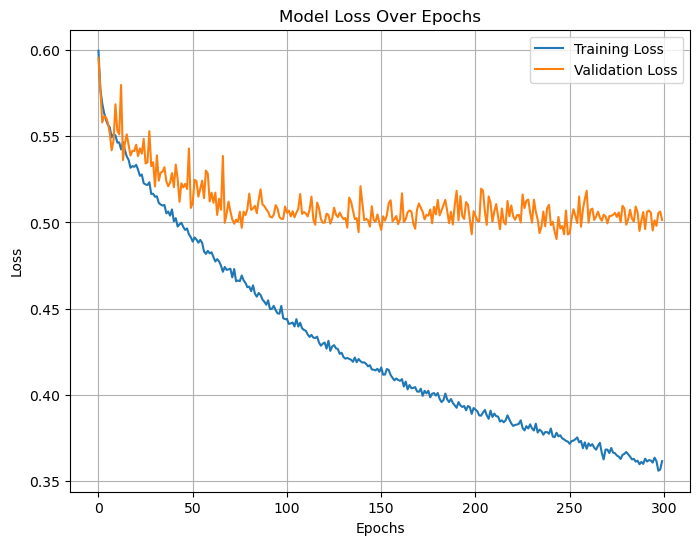

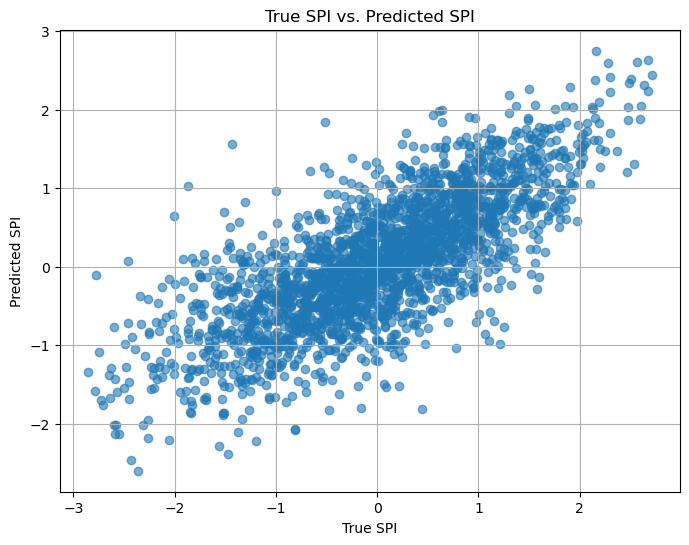

Mean Absolute Error (MAE): 0.5013157856880616
Pearson Correlation Coefficient: 0.7584547352475712


In [20]:
# Test
y2_pred = model.predict(X2_test).flatten()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Predicted vs Actual SPI
plt.figure(figsize=(8, 6))
plt.scatter(y2_test, y2_pred, alpha=0.6)
plt.title('True SPI vs. Predicted SPI')
plt.xlabel('True SPI')
plt.ylabel('Predicted SPI')
plt.grid(True)
plt.show()

# Calculate MAE
mae = mean_absolute_error(y2_test, y2_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Pearson
corr_matrix = np.corrcoef(y2_test, y2_pred)
pearson_corr = corr_matrix[0, 1]
print(f"Pearson Correlation Coefficient: {pearson_corr}")

In [21]:
# model.save('regression_modelv2.keras') #

In [22]:
regression_model = load_model('regression_modelv2.keras')

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


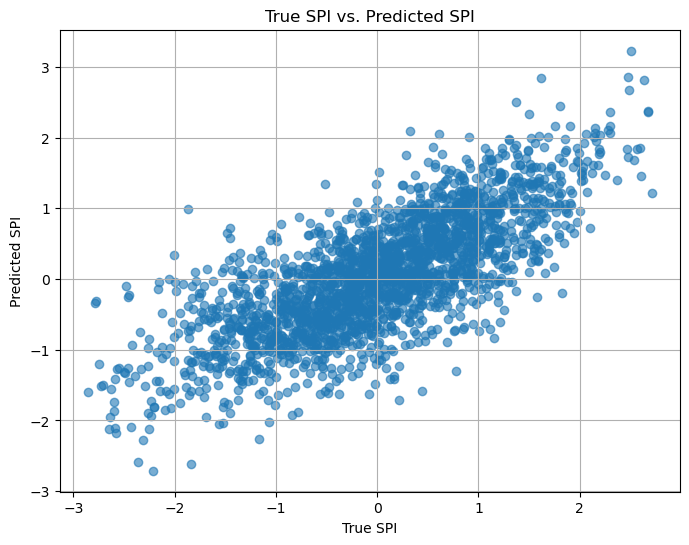

Mean Absolute Error (MAE): 0.5102022936757711
Pearson Correlation Coefficient: 0.7553319731480509


In [35]:
# Test
y2_pred = regression_model.predict(X2_test).flatten()

# Plot Loss
# plt.figure(figsize=(8, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend(loc='upper right')
# plt.grid(True)
# plt.show()

# Predicted vs Actual SPI
plt.figure(figsize=(8, 6))
plt.scatter(y2_test, y2_pred, alpha=0.6)
plt.title('True SPI vs. Predicted SPI')
plt.xlabel('True SPI')
plt.ylabel('Predicted SPI')
plt.grid(True)
plt.show()

# Calculate MAE
mae = mean_absolute_error(y2_test, y2_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate Pearson
corr_matrix = np.corrcoef(y2_test, y2_pred)
pearson_corr = corr_matrix[0, 1]
print(f"Pearson Correlation Coefficient: {pearson_corr}")